In [22]:
import numpy as np
import pickle
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize OpenAI for Pong
env = gym.make("Pong-v0")

# Hyper parameters for policy gradient model
global num_actions, discount
num_actions = 3 
discount = 0.99

# Hyper parameters for Network
learning_rate=0.001
FC_param = {'FC_1':200}
decay_ = 0.99
epsilon_ = 1e-8

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std1, action_hist, reward_hist, reward_runn = [], [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_, FC_param):
    
    FC_tmp = tf.contrib.layers.flatten(image_, scope='Flatten')
    
    for key,value in FC_param.items():
        FC_tmp = tf.layers.dense(inputs=FC_tmp, 
                                 units=value,
                                 kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                     stddev=1./np.sqrt(5000), 
                                                                                     dtype=tf.float32),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name=key)
    
    logits = tf.layers.dense(inputs=FC_tmp, 
                             units=num_actions, 
                             kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                 stddev=1./np.sqrt(500), 
                                                                                 dtype=tf.float32),
                             use_bias=False,
                             name='Logits')
    
    action_probs = tf.nn.softmax(logits, name='SoftMax')
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    rew_func = lambda a, v: a*discount + v # Reward function
    
    rew_reverse = tf.scan(rew_func, tf.reverse(rew,[True, False]))
    discounted_rew = tf.reverse(rew_reverse,[True, False])
    
    mean, variance= tf.nn.moments(discounted_rew, [0])
    discounted_rew -= mean
    discounted_rew /= tf.sqrt(variance + 1e-6)
    
    return discounted_rew

# Process image by cropping and binarizing
def process_obs(obs):
    obs = obs[35:195]
    obs = obs[::2,::2,0]
    obs[obs == 144] = 0
    obs[obs == 109] = 0
    obs[obs != 0] = 1 
    return obs.astype(np.float)

# Build model
with tf.Graph().as_default() as g:
    with tf.device("/cpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 80,80,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")

        discounted_epr = discount_norm(reward_) # Get policy gradient
        tf_aprob = Network(image_,FC_param)
        
        PG = tf.multiply(discounted_epr, tf.subtract(fake_label_,tf_aprob))

# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    episode_number = pickle.load(open('PG-Pong-ckpt-1/last-episode.p','rb'))
    saver.restore(sess, 'PG-Pong-ckpt-1\\Pong_PG.ckpt-'+str(episode_number))
    
    done = False
    while not done:
    
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((80,80))
        image_old = image_proc

        # Uniformly pick an action
        feed_step = {image_: np.reshape(image_diff, (1,80,80,1))}
        aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
        action = np.random.choice(num_actions, p=aprob)
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+1)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std1.append(reward)

        if done:
            feed_episode = {image_: np.array(images).reshape(-1, 80, 80, 1), 
                    fake_label_: np.array(fake_labels).reshape(-1,num_actions), 
                    reward_: np.array(rewards_std1).reshape(-1,1)}

            PG1 = sess.run(PG,feed_episode)
            dlogp1 = sess.run(discounted_epr,feed_episode)
        

[2017-05-03 13:15:42,530] Making new env: Pong-v0


In [23]:
import numpy as np
import pickle
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize OpenAI for Pong
env = gym.make("Breakout-v0")

# Hyper parameters for policy gradient model
global num_actions, discount
num_actions = 3 
discount = 0.99

# Hyper parameters for Network
learning_rate=0.001
FC_param = {'FC_1':600}
decay_ = 0.99
epsilon_ = 1e-8

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std2, action_hist, reward_hist, reward_runn = [], [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_, FC_param):
    
    FC_tmp = tf.contrib.layers.flatten(image_, scope='Flatten')
    
    for key,value in FC_param.items():
        FC_tmp = tf.layers.dense(inputs=FC_tmp, 
                                 units=value,
                                 kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                     stddev=1./np.sqrt(5000), 
                                                                                     dtype=tf.float32),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name=key)
    
    logits = tf.layers.dense(inputs=FC_tmp, 
                             units=num_actions,
                             kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                 stddev=1./np.sqrt(500), 
                                                                                 dtype=tf.float32),
                             use_bias=False,
                             name='Logits')
    
    action_probs = tf.nn.softmax(logits, name='SoftMax')
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    rew_func = lambda a, v: a*discount + v # Reward function
    
    rew_reverse = tf.scan(rew_func, tf.reverse(rew,[True, False]))
    discounted_rew = tf.reverse(rew_reverse,[True, False])
    
    mean, variance= tf.nn.moments(discounted_rew, [0])
    discounted_rew -= mean
    discounted_rew /= tf.sqrt(variance + 1e-6)
    
    return discounted_rew

# Process image by cropping and binarizing
def process_obs(obs):
    obs = obs[32:196,8:152]
    obs = obs[::2,::2,0]
    obs[obs != 0] = 1 
    return obs.astype(np.float)

# Build model
with tf.Graph().as_default() as g:
    with tf.device("/cpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 82, 72,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")

        discounted_epr = discount_norm(reward_) # Get policy gradient
        tf_aprob = Network(image_,FC_param)
        
        PG = tf.multiply(discounted_epr, tf.subtract(fake_label_,tf_aprob))


# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    episode_number = pickle.load(open('PG-Breakout-ckpt-1/last-episode.p','rb'))
    saver.restore(sess, 'PG-Breakout-ckpt-1\\Breakout.ckpt-'+str(episode_number))
    
    done = False
    while not done:
    
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((82,72))
        image_old = image_proc

        # Uniformly pick an action
        feed_step = {image_: np.reshape(image_diff, (1,82,72,1))}
        aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
        action = np.random.choice(num_actions, p=aprob)
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+1)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std2.append(reward)

        if done:
            feed_episode = {image_: np.array(images).reshape(-1, 82, 72, 1), 
                    fake_label_: np.array(fake_labels).reshape(-1,num_actions), 
                    reward_: np.array(rewards_std2).reshape(-1,1)}

            PG2 = sess.run(PG,feed_episode)
            dlogp2 = sess.run(discounted_epr,feed_episode)
            

[2017-05-03 13:16:13,643] Making new env: Breakout-v0


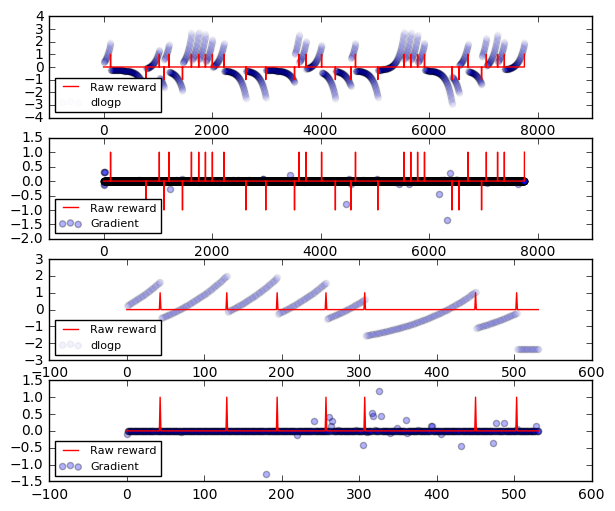

In [35]:
fig,axe = plt.subplots(4,1,figsize=(7,6))
axe[0].scatter(range(len(dlogp1)),dlogp1,label='dlogp',alpha=0.01)
axe[0].plot(rewards_std1,label='Raw reward',c='r')
axe[0].legend(loc=3,fontsize=8)
axe[2].scatter(range(len(dlogp2)),dlogp2,label='dlogp',alpha=0.05)
axe[2].plot(rewards_std2,label='Raw reward',c='r')
axe[2].legend(loc=3,fontsize=8)
axe[1].scatter(range(len(PG1[:,0])),PG1[:,0],label='Gradient',alpha=0.3)
axe[1].plot(rewards_std1,label='Raw reward',c='r')
axe[1].legend(loc=3,fontsize=8)
axe[3].scatter(range(len(PG2[:,0])),PG2[:,0],label='Gradient',alpha=0.3)
axe[3].plot(rewards_std2,label='Raw reward',c='r')
axe[3].legend(loc=3,fontsize=8)
plt.show()
fig.savefig('Plots/Advantage_function.jpg')